### HUYNH Minh-Hoang

## Importation

In [170]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, exposure, filters, morphology, measure
from scipy import signal
import cv2
import pandas as pd

# Mini projet : Morphogranulométrie

On souhaite débruiter l'image, puis la segmenter pour compter le nombre d'agrégat et connaître leur caractéristiques

## Image d'entrée

Étudions d'abord l'image et son histogramme. Entrons ici le chemin vers l'image, ici `Exp2_3h.77vms9sv.000000-0.0000..jpg`

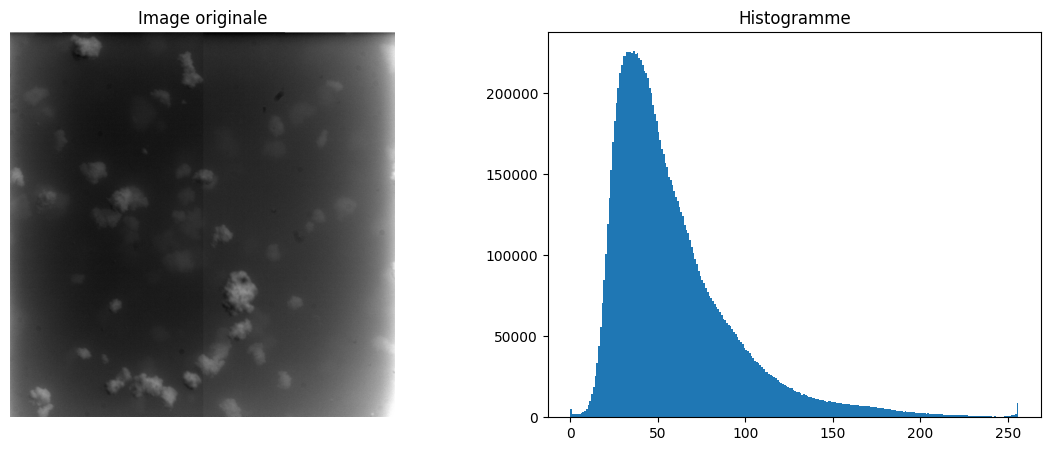

Moyenne : 58.590481996536255
Std : 35.14887038456061
Argmax : 36


In [8]:
img = io.imread('images_miniprojet\Exp2_3h.77vms9sv.000000-0.0000..jpg')

_,ax = plt.subplots(1,2, figsize=(14,5))

ax[0].imshow(img)
ax[0].set_title('Image originale')
ax[0].axis('off')
ax[1].hist(img.flatten(), 256, range=(0,256))
ax[1].set_title('Histogramme')
plt.show()

print('Moyenne : '+str(np.mean(img.flatten())))
argmax = np.histogram(img.flatten(), 256, range=(0,256))[0].argmax()
print('Std : '+str(np.std(img.flatten())))
print('Argmax : '+str(argmax))

L'image présente un éclairage hétérogène, plus éclairé sur les côtés et plus sombre au centre. Cela ne permet pas la distinction clair des agrégats comme on peut le voir sur l'histogramme des niveaux de gris

## Correction gamma

Moyenne (0.35)	 : 146.64918446540833
Moyenne (0.44)	 : 127.97573280334473
Moyenne (0.5)	 : 117.04437208175659
Moyenne (0.65)	 : 94.13466501235962
Moyenne (0.85)	 : 71.15830659866333
Moyenne (1)	 : 58.43216037750244
Moyenne (1.2)	 : 44.802496910095215


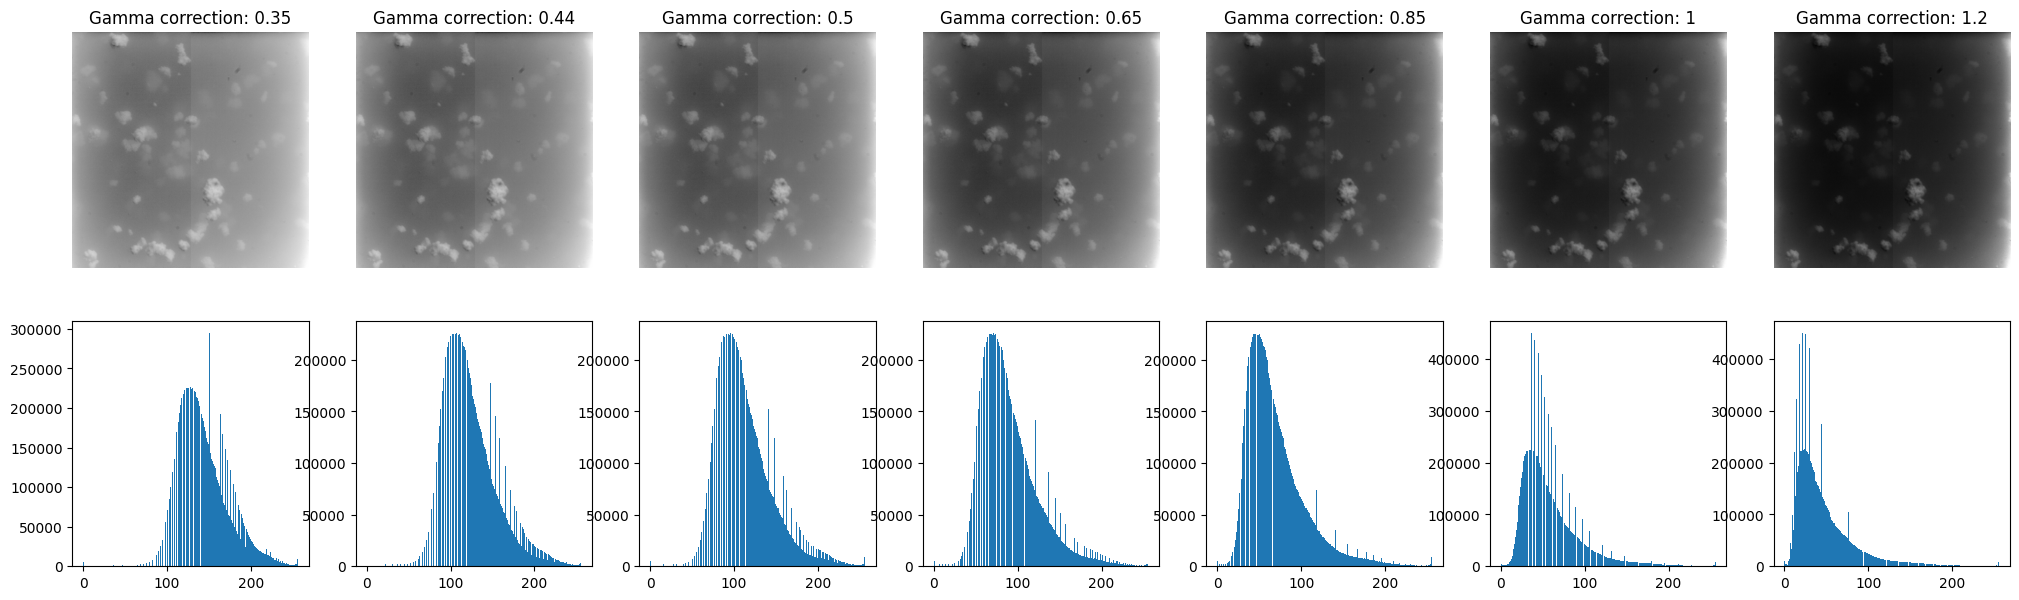

In [9]:
plt.figure(figsize=(25, 7))

L = [0.35,0.44,0.5,0.65,0.85,1,1.2]
n = len(L)
for i, k in enumerate(L):
    img_gamma = exposure.adjust_gamma(img, k, gain=1)
    plt.subplot(2, n, i+1)
    plt.imshow(img_gamma)
    plt.axis('off')
    plt.title('Gamma correction: '+str(k))
    plt.subplot(2, n, i+n+1)
    plt.hist(img_gamma.flatten(), 256, range=(0,256))
    print('Moyenne ('+str(k)+')\t : '+str(np.mean(img_gamma)))

Pour essayer d'uniformiser les niveaux de gris de l'image, on essaie de réduire l'étendue de gris. On voit qu'en réduisant `gamma` que la moyenne se déplace à droite, éclaircissant l'image.
On essaie de réduire de moitié de sorte à obtenir une moyenne de 128

Moyenne (0.4)	: 58.34406852722168
Moyenne (0.46)	: 67.1724944114685
Moyenne (0.5)	: 73.07770609855652
Moyenne (0.65)	: 95.16795063018799
Moyenne (0.85)	: 124.6008689403534


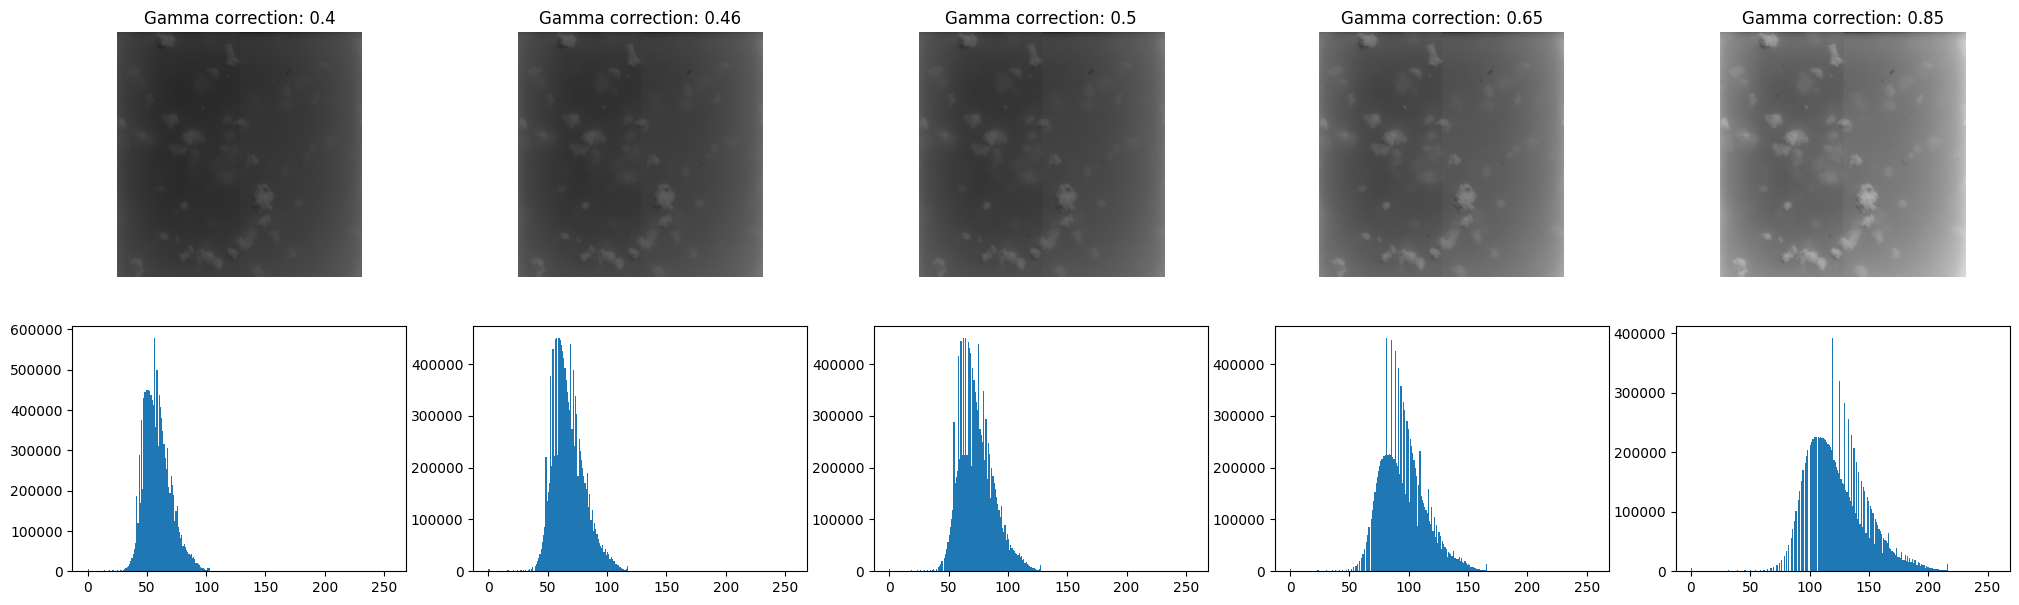

In [10]:
plt.figure(figsize=(25, 7))

L = [0.4,0.46,0.5,0.65,0.85]
n = len(L)
for i, k in enumerate(L):
    img_gamma = exposure.adjust_gamma(img, 0.35, gain=k)
    plt.subplot(2, n, i+1)
    plt.imshow(img_gamma)
    plt.axis('off')
    plt.title('Gamma correction: '+str(k))
    plt.subplot(2, n, i+n+1)
    plt.hist(img_gamma.flatten(), 256, range=(0,256))
    print('Moyenne ('+str(k)+')\t: '+str(np.mean(img_gamma)))

On voit ici que réduire le gain assombrit l'image et compresse l'histogramme vers la gauche, et vice-versa en l'augmentant.
On reprend celle avec un gain de 0.46 qui amène à la même moyenne que l'image originale

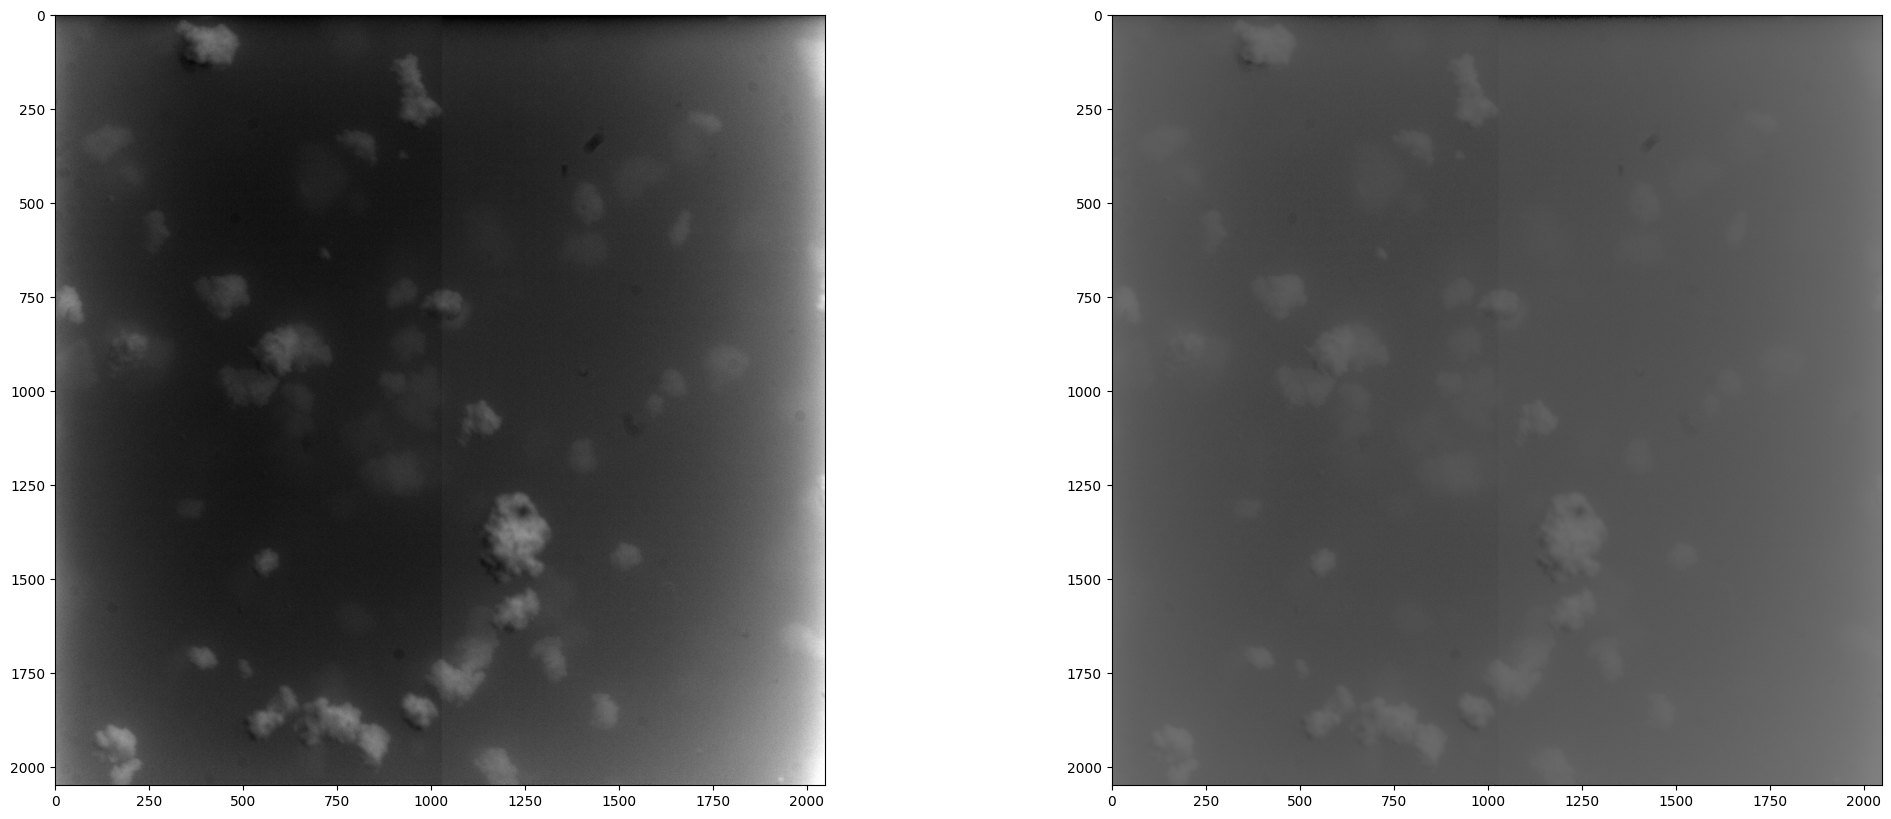

In [79]:
img_gamma = exposure.adjust_gamma(img, 0.25, gain=0.5)


_, ax = plt.subplots(1,2, figsize=(25,10))
ax[0].imshow(img, 'gray')
ax[1].imshow(img_gamma, 'gray')
plt.show()

Ici, on a réussi à mieux uniformiser les niveaux de gris de l'image. On peut essayer ensuite d'augmenter le contraste. L'étirement d'histogramme et l'égalisation d'histogramme n'ont pas marché, on peut essayer un seuillage local pour avoir un meilleur contraste.

## Local Threshold

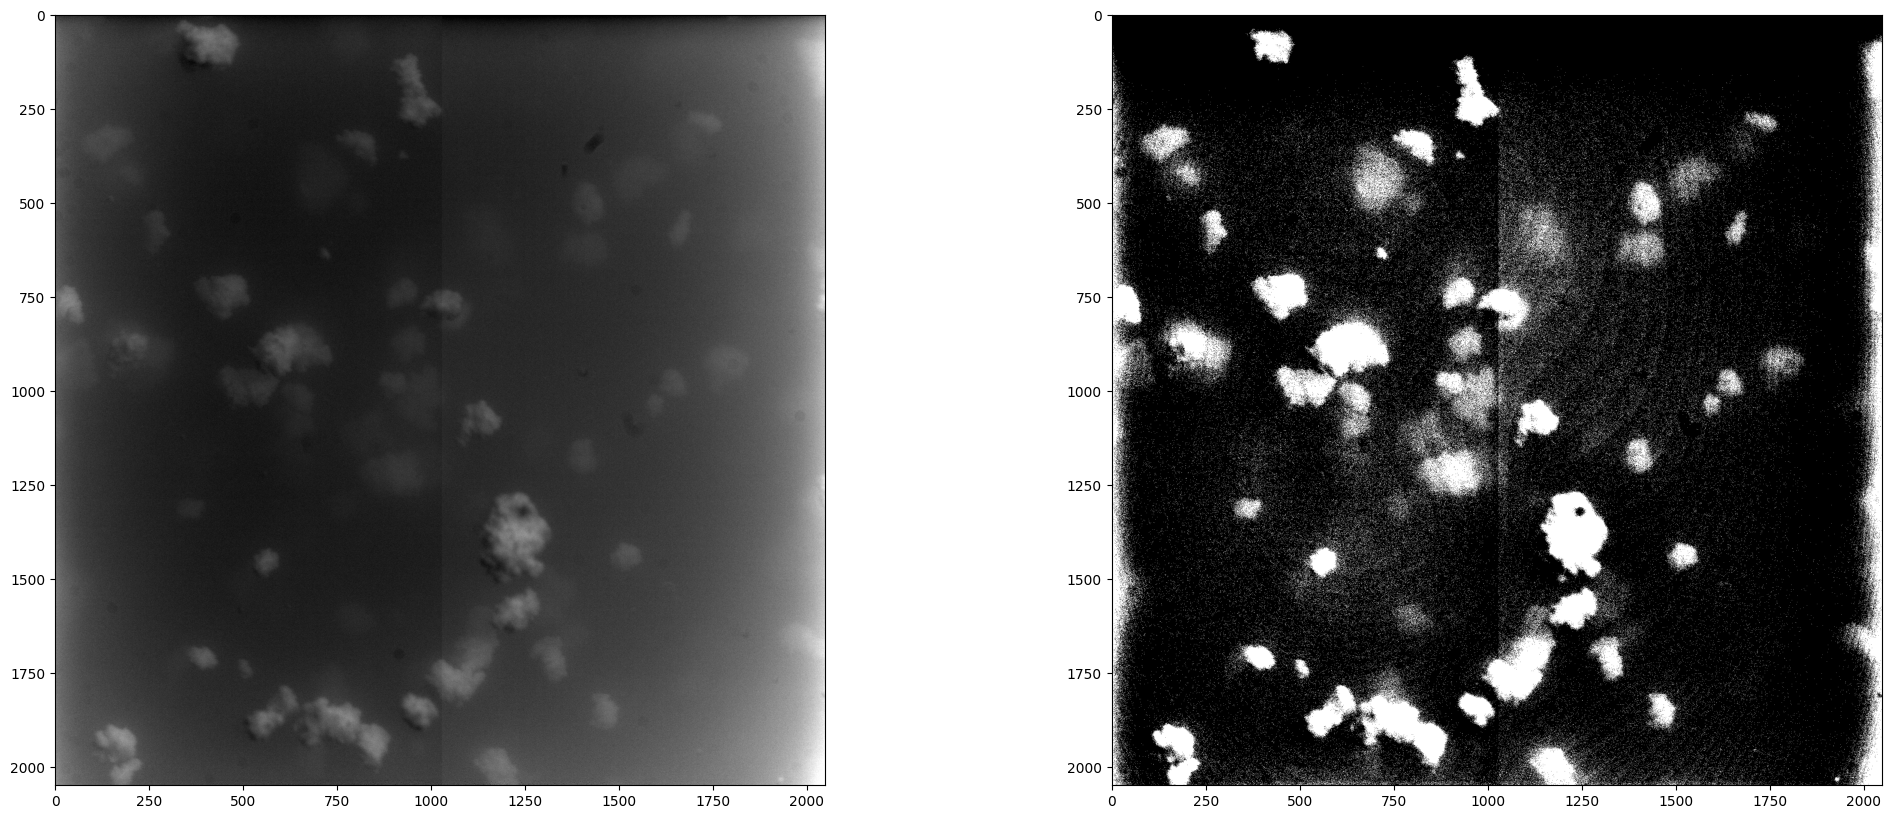

In [88]:
img_gray = cv2.cvtColor(img_gamma, cv2.COLOR_BGR2GRAY)
img_lth = cv2.adaptiveThreshold(img_gray, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,1005,-2)

_, ax = plt.subplots(1,2, figsize=(25,10))
ax[0].imshow(img, 'gray')
ax[1].imshow(img_lth, 'gray')

On parvient à faire ressortir les agrégats principaux de l'image avec quelques agrégats en arrière plan. Essayons de diminuer le bruitage en appliquant un filtre spatial qui va lisser l'image. Cela marche très bien avec un filtre médian

## Restoration filtering

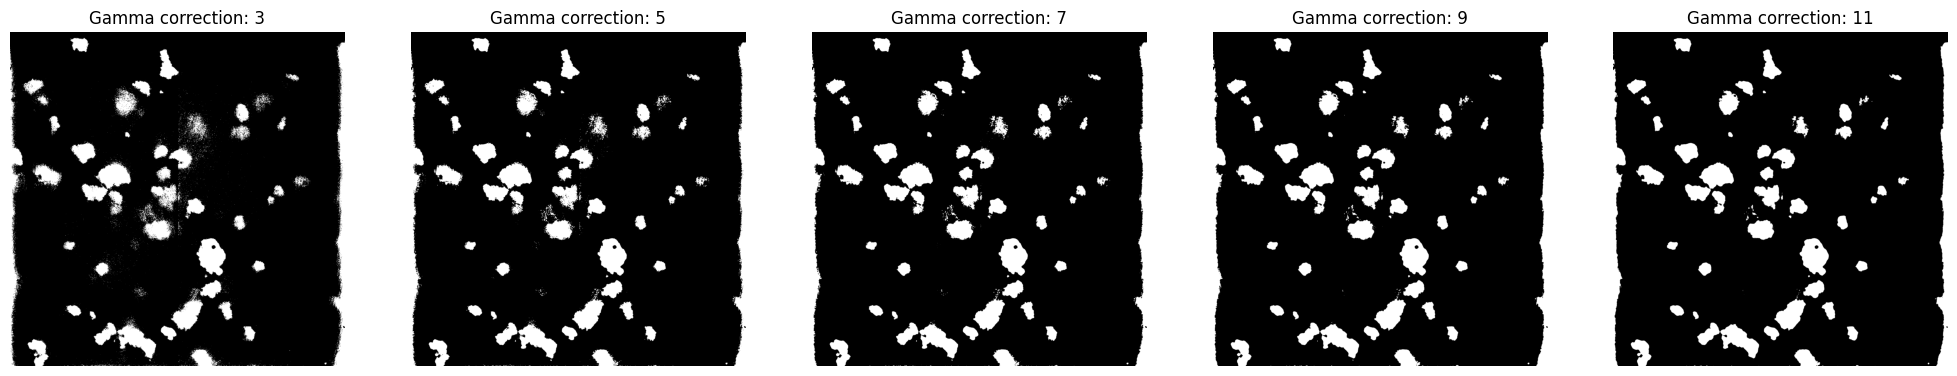

In [90]:
plt.figure(figsize=(25, 7))

L = [3,5,7,9,11]
n = len(L)
for i, k in enumerate(L):
    img_median = cv2.medianBlur(img_lth, k)
    plt.subplot(1, n, i+1)
    plt.imshow(img_median, 'gray')
    plt.axis('off')
    plt.title('Gamma correction: '+str(k))

On obtient donc avec un paramètre k=7

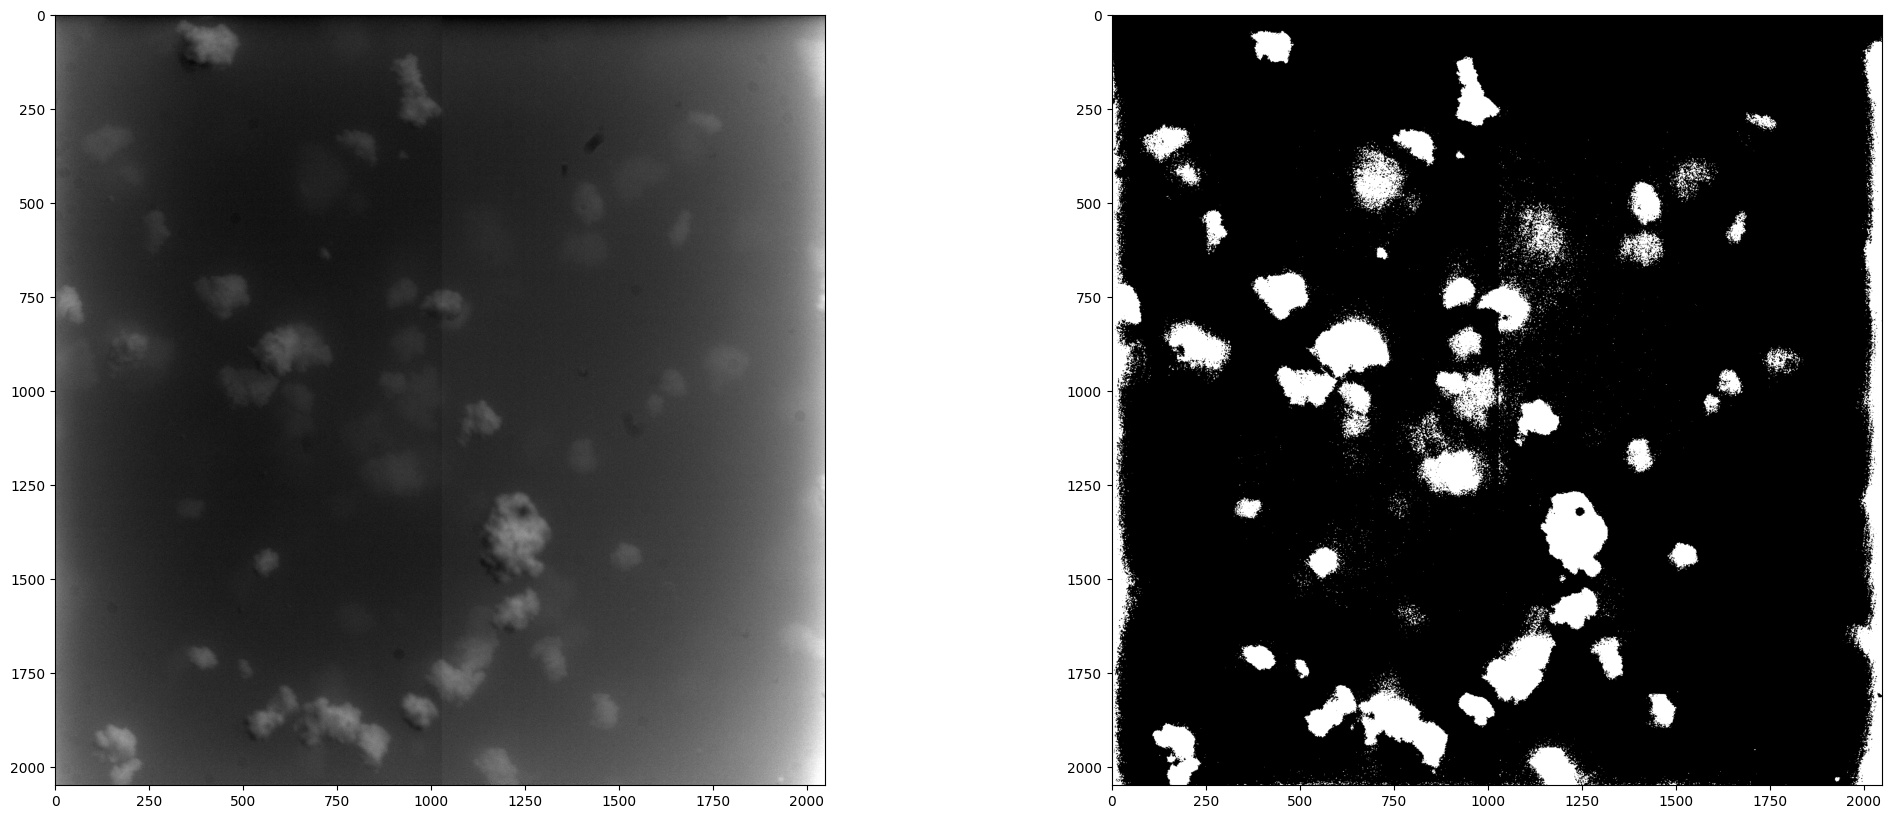

In [91]:
img_median = cv2.medianBlur(img_lth, 3)

_, ax = plt.subplots(1,2, figsize=(25,10))
ax[0].imshow(img, 'gray')
ax[1].imshow(img_median, 'gray')

## Segmentation

On essaie de nettoyer l'image en enlevant les objets parasite de petites taill et en réalisant une fermeture morphologique

c:\ProgramData\Miniconda3\lib\site-packages\skimage\_shared\utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


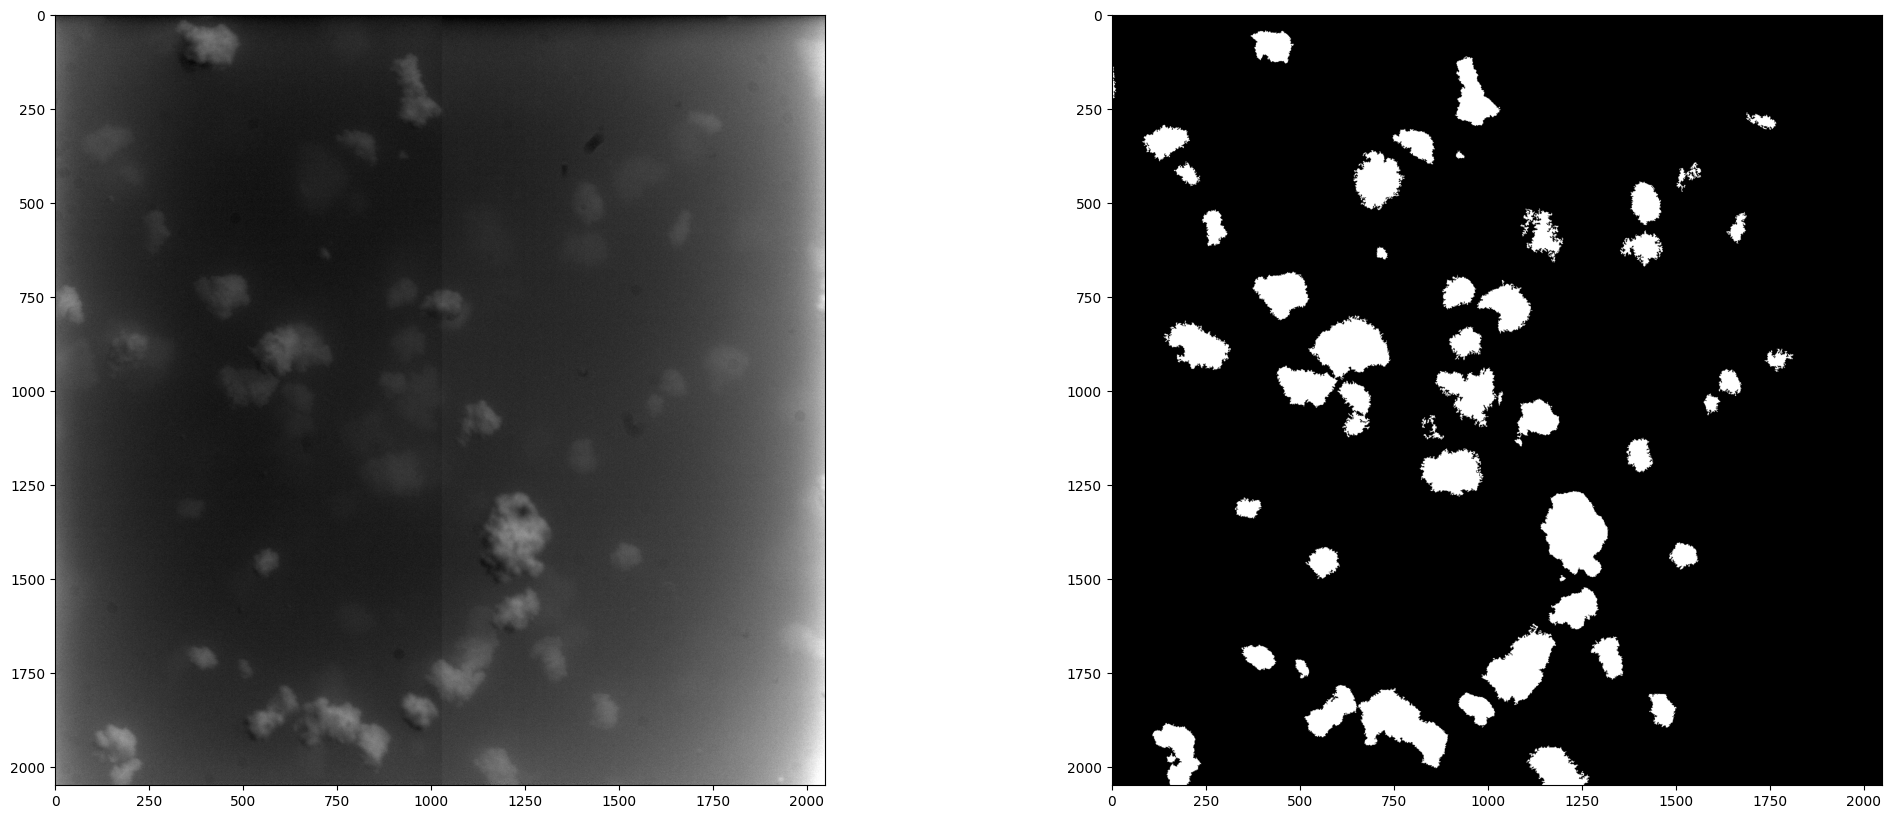

In [158]:
img_seg = morphology.remove_small_holes(img_median, 500)    
img_seg = morphology.remove_small_objects(img_seg, 130)
L = morphology.label(img_seg, connectivity=2)               # On enlève les régions parasite en bord gauche et droite
M = np.where(L == L[750,0], 0, L)
N = np.where(M == L[2000,2000], 0, M)
img_seg = np.where(N == 0, 0, img_seg)

_, ax = plt.subplots(1,2, figsize=(25,10))
ax[0].imshow(img, 'gray')
ax[1].imshow(img_seg, 'gray')

On a segmenté les principaux agrégats. Voici une fonction qui résume l'ensemble des transformations effectuées

c:\ProgramData\Miniconda3\lib\site-packages\skimage\_shared\utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


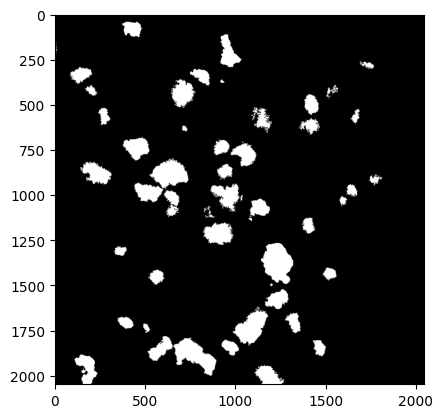

In [163]:
def segmentation(image):
    # Ajustement gamma pour le niveau de gris
    img_gamma = exposure.adjust_gamma(image, 0.25, gain=0.5)
    # Seuillage local pour le contraste
    img_gray = cv2.cvtColor(img_gamma, cv2.COLOR_BGR2GRAY)
    img_lth = cv2.adaptiveThreshold(img_gray, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,1005,-2)
    # Filtre médian pour lisser
    img_median = cv2.medianBlur(img_lth, 3)
    # Nettoyage morphologique
    img_seg = morphology.remove_small_holes(img_median, 500)    
    img_seg = morphology.remove_small_objects(img_seg, 130)
    L = morphology.label(img_seg, connectivity=2)               # On enlève les régions parasite en bord gauche et droite
    M = np.where(L == L[750,0], 0, L)
    N = np.where(M == L[2000,2000], 0, M)
    img_seg = np.where(N == 0, 0, img_seg)
    return img_seg

plt.imshow(segmentation(img), 'gray')

## Mesure de caractéristiques

On a segmenté l'image avec les principaux agrégats. On peut donc tenter de les compter

In [183]:
len(np.unique(N))-1      # On enlève 1 pour ne pas compter l'arrière plan qui est 0

54

On compte 54 agrégats dans cette image. Relevons maintenant quelques caractéristiques des agrégats

In [182]:
props = measure.regionprops(measure.label(img_seg))
table_props = pd.DataFrame({'Perimeter':[], 'Area':[], 'Convex Area':[], 'Eccentricity':[], 'Major Axis Length':[], 'Minor Axis Length':[]})

for i, p in enumerate(props):
    table_props.loc[i] = [p.perimeter, p.area, p.convex_area, p.eccentricity, p.major_axis_length, p.minor_axis_length]
table_props

Perimeter     Area  Convex Area  Eccentricity  Major Axis Length   
0   2911.000000   2911.0       4096.0      1.000000        2625.039648  \
1    491.830519   6748.0       7955.0      0.655206         109.521990   
2    745.115836  11211.0      15023.0      0.885315         193.802948   
3    223.124892    479.0        730.0      0.994729          88.424784   
4    443.060967   1628.0       2423.0      0.924344          80.512933   
5    695.511760   6645.0       8182.0      0.765456         117.575286   
6    540.872150   5712.0       6767.0      0.834223         120.215796   
7   1242.750396  12985.0      16038.0      0.575126         145.162416   
8     85.769553    275.0        358.0      0.700003          23.502274   
9    378.670094   2044.0       2748.0      0.785901          67.756356   
10   144.396970    269.0        523.0      0.869786          36.940674   
11   486.853860   1050.0       2665.0      0.784768          71.721940   
12   535.730014   6357.0       7390.0      0.732949         110.044607   
13  1316.792027   5774.0       9365.0      0.779521         123.042232   
14   263.172619    550.0       1001.0      0.834543          44.270906   
15   434.161472   3737.0       4703.0      0.840735          98.065116   
16   408.019336   1970.0       2767.0      0.891338          80.008907   
17   138.189863    203.0        479.0      0.804190          33.211294   
18   959.542243   5194.0       7486.0      0.692909         103.417970   
19   131.018290    650.0        767.0      0.673032          34.344906   
20   717.653896  11942.0      13612.0      0.562534         139.797752   
21   542.593975   5181.0       6177.0      0.609812          93.238708   
22   887.885389  10537.0      14004.0      0.614125         137.718954   
23  1989.274349  32731.0      45457.0      0.892532         343.190534   
24  1202.856998  12663.0      16287.0      0.818070         173.283618   
25   622.529004   4628.0       6002.0      0.501016          85.064697   
26   515.380772   1921.0       3155.0      0.667696          64.620680   
27  1619.520995  13741.0      20016.0      0.650547         168.521053   
28   415.161472   2763.0       3367.0      0.624057          69.262196   
29  1080.531096   7090.0      10527.0      0.882570         159.752120   
30   268.072114   1324.0       1812.0      0.600557          48.037457   
31   576.221392   7647.0       9365.0      0.495775         109.597234   
32   125.568542    195.0        387.0      0.762805          27.160200   
33    90.355339    141.0        254.0      0.923007          27.892356   
34   280.687338    544.0       1409.0      0.495919          47.229264   
35   522.801082   4204.0       5082.0      0.714576          89.555069   
36    73.905592    220.0        274.0      0.808290          23.343992   
37  1154.087445  14447.0      17363.0      0.693559         162.555072   
38   974.045815  27107.0      30459.0      0.719480         225.945815   
39   352.877200   2548.0       3064.0      0.668905          67.882897   
40   403.090404   3446.0       4019.0      0.460260          71.594769   
41   467.374675   4569.0       5491.0      0.315541          79.442161   
42    55.698485    148.0        193.0      0.432071          15.869929   
43   637.641702   8825.0      10477.0      0.758740         134.657474   
44  1272.804220  20930.0      24984.0      0.807758         218.961296   
45   564.907684   5638.0       7051.0      0.826120         117.828294   
46   362.019336   4012.0       4489.0      0.774315          90.693707   
47   206.308658   1135.0       1391.0      0.839648          53.601901   
48   735.618362   9206.0      11510.0      0.892930         169.131489   
49  1307.253967  24178.0      32288.0      0.884563         279.876956   
50   375.948268   5012.0       5672.0      0.776003         103.310135   
51   461.232539   4226.0       5160.0      0.773811          94.492226   
52   865.465079  11433.0      15038.0      0.840117         182.886167   
53   911.0